# Exercise 2: Continuous Time Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Transition rates from Ex 1
# Nodes: o, a, b, c, d
Lambda = np.array([
    [0.0, 2/5, 1/5, 0.0, 0.0],
    [0.0, 0.0, 3/4, 1/4, 0.0],
    [1/2, 0.0, 0.0, 1/3, 0.0],
    [0.0, 0.0, 1/3, 0.0, 2/3],
    [0.0, 1/3, 0.0, 1/3, 0.0]
])
nodes = ['o', 'a', 'b', 'c', 'd']
n = len(nodes)

# Calculate w (exit rates) and P (jump matrix)
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# Uniformization setup
w_star = np.max(w)
P_bar = Lambda / w_star
# Add self loops
for i in range(n):
    P_bar[i, i] += 1 - np.sum(P_bar[i])

# Theoretical stationary distribution pi
vals, vecs = np.linalg.eig(P_bar.T)
pi = vecs[:, np.argmin(np.abs(vals - 1))].real
pi = pi / np.sum(pi)

print("Exit rates w:", w)
print("Stationary pi:", pi)

Exit rates w: [0.6        1.         0.83333333 1.         0.66666667]
Stationary pi: [0.2173913  0.14906832 0.26086957 0.1863354  0.1863354 ]


### Part a) Average return time for particle in 'a'

In [2]:
# Simulate single particles with local clocks
n_sim = 5000
start_node = 1 # index for 'a'
times = []

for i in range(n_sim):
    curr = start_node
    t = 0
    while True:
        # Sample holding time (exp rate w_i)
        dt = -np.log(np.random.rand()) / w[curr]
        t += dt
        
        # Jump
        curr = np.random.choice(n, p=P[curr])
        
        if curr == start_node:
            times.append(t)
            break

sim_val = np.mean(times)

# Theoretical: E[T] = 1 / (pi_i * w_i)
theo_val = 1 / (pi[start_node] * w[start_node])

print(f"Simulated return time: {sim_val:.4f}")
print(f"Theoretical return time: {theo_val:.4f}")

Simulated return time: 6.7551
Theoretical return time: 6.7083


### Part b) Node perspective simulation

In [3]:
# Using Global Clock simulation
N_particles = 1000
T_max = 600

# All start at 'a'
counts = np.zeros(n)
counts[1] = N_particles 

t = 0
global_rate = N_particles * w_star

# Store history
hist_t = [0]
hist_counts = [counts.copy()]

while t < T_max:
    # Time to next system event
    t += -np.log(np.random.rand()) / global_rate
    
    # Pick a particle to move (weighted by counts at nodes)
    node_probs = counts / N_particles
    src = np.random.choice(n, p=node_probs)
    
    # Move it using P_bar (uniformized matrix)
    dst = np.random.choice(n, p=P_bar[src])
    
    counts[src] -= 1
    counts[dst] += 1
    
    hist_t.append(t)
    hist_counts.append(counts.copy())

hist_counts = np.array(hist_counts)

print("Final distribution:", counts)
print("Expected (N*pi):", (pi * N_particles).astype(int))

Final distribution: [225. 152. 257. 178. 188.]
Expected (N*pi): [217 149 260 186 186]


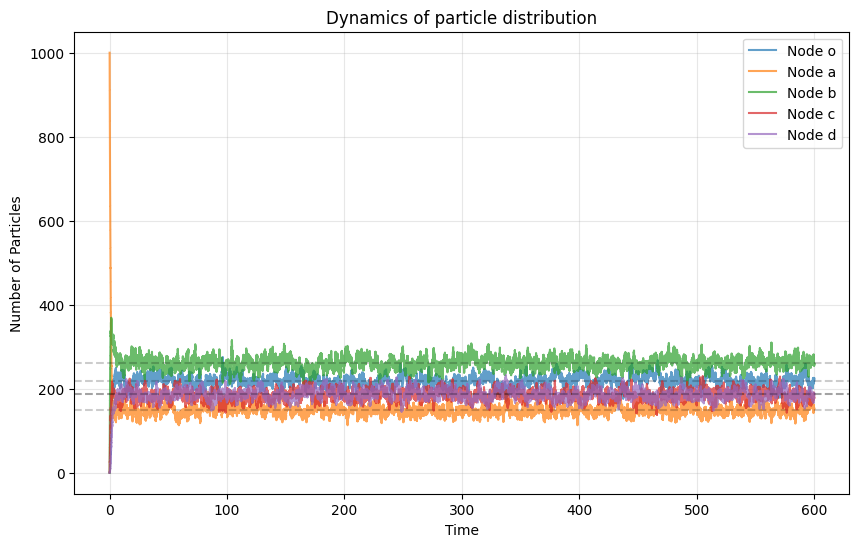

In [4]:
# Plotting results
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.step(hist_t, hist_counts[:, i], label=f"Node {nodes[i]}", alpha=0.7)
    # Plot theoretical average as dashed line
    plt.axhline(y=pi[i]*N_particles, color='black', linestyle='--', alpha=0.2)

plt.xlabel("Time")
plt.ylabel("Number of Particles")
plt.title("Dynamics of particle distribution")
plt.legend()
plt.grid(alpha=0.3)
plt.show()